In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import scipy.signal
from scipy.signal import windows
scipy.signal.gaussian = windows.gaussian

import jax
import time
import json
import json
import torch
import pickle
import pprint
import pathlib
import textwrap
import numpy as np
import arviz as az
import pandas as pd
import seaborn as sns 
import multiprocessing as mp
import sbi.utils as sbi_utils
import matplotlib.pyplot as plt

from tqdm import tqdm
from scipy import stats
from pathlib import Path
from sbi import utils as sbi_utils
from mf_npe.pipeline import Pipeline
from sbi.inference import simulate_for_sbi, SNPE
from multiprocessing import Pool, cpu_count
from mf_npe.config.TaskSetup import TaskSetup
from mf_npe.diagnostics.ppc import summarize_voltage 
from mf_npe.simulator.stochastic_hh import markov_hh              # HF Simulator
from mf_npe.simulator.noisy_hh import hh_current_noise            # LF Simulator
from sbi.utils.simulation_utils import simulate_for_sbi
from mf_npe.utils.utils import summarize_voltage, set_global_seed

/var/autofs/misc/home/petera/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## NPE with low-fidelity simulation on low-fidelity observed data (Self-Consistent)

In [ ]:
# ─────────────────────────────────────────────────────────────────────────────
# 1. GLOBAL SEED‐SETTING
# ─────────────────────────────────────────────────────────────────────────────
def set_global_seed(s: int):
    np.random.seed(s)
    torch.manual_seed(s)

# ─────────────────────────────────────────────────────────────────────────────
# 2. CONSTANTS & PATHS
# ─────────────────────────────────────────────────────────────────────────────
ROOT = pathlib.Path("npe_demo/lf_npe")
ROOT.mkdir(parents=True, exist_ok=True)

# Path to HF observation (needed for NLTP evaluation & PPC overlay)
OBS_PATH = pathlib.Path("lf_trace/noisy_ground_truth_trace.npz")

# **Define** where to save/load your LF training dataset
LF_TRAIN_PATH = ROOT / "lf_training_data_1m.pt"

# Number of new LF simulations to generate if you choose to regenerate:
N_LF_SIM    = 1000_000
N_WORKERS   = 19
SEED_DATA   = 2025
SEED_SIM_LF = 123

torch.set_default_dtype(torch.float32)
set_global_seed(SEED_DATA)

# ─────────────────────────────────────────────────────────────────────────────
# 3. LOAD LF OBSERVATION (for NLTP & PPC overlays)
# ─────────────────────────────────────────────────────────────────────────────
load_start = time.time()
obs_npz = np.load(OBS_PATH)
t_vec   = obs_npz["t"]            # 0 … 50 ms at dt=0.01 ms
V_obs   = obs_npz["V_lo"]         # observed HF voltage trace (for overlay)
x_obs   = torch.as_tensor(obs_npz["summary"], dtype=torch.float32)
obs_time = time.time() - load_start

theta_true = (
    torch.as_tensor(obs_npz["theta_L"], dtype=torch.float32)
    if "theta_L" in obs_npz
    else torch.tensor([120.0, 36.0, 0.30], dtype=torch.float32)
)

print(f"Loaded HF observation from {OBS_PATH.resolve()}  (dt={t_vec[1]-t_vec[0]:.3f} ms)")

# ─────────────────────────────────────────────────────────────────────────────
# 4. TIME GRID & STIMULUS (for LF, matching `hh_current_noise` signature)
# ─────────────────────────────────────────────────────────────────────────────
dt, t_max = t_vec[1] - t_vec[0], t_vec[-1]
# NOTE: hh_current_noise's signature already “knows” the fixed time grid internally,
# but we keep `t_vec, dt` in case you need to inspect it or pass into summary.

# ─────────────────────────────────────────────────────────────────────────────
# 5. PRIOR OVER PARAMETERS
# ─────────────────────────────────────────────────────────────────────────────
prior = sbi_utils.BoxUniform(
    low  = torch.tensor([50.0, 20.0, 0.1]),
    high = torch.tensor([200.0, 100.0, 1.0])
)

# ─────────────────────────────────────────────────────────────────────────────
# 6. LF SIMULATOR WRAPPER
# ─────────────────────────────────────────────────────────────────────────────
def sim_and_summarize_lf(theta_batch):
    """
    For each θ = (gNa, gK, gL) in theta_batch,
    run `hh_current_noise` (LF) once and return summary stats (B,4).
    """
    if not torch.is_tensor(theta_batch):
        theta_batch = torch.as_tensor(theta_batch, dtype=torch.float32)

    out = []
    # We fix a “master” JAX key so that the noise in LF is reproducible.
    master_key = jax.random.PRNGKey(SEED_SIM_LF)
    theta_list = theta_batch.tolist()

    for (gNa, gK, gL) in theta_list:
        # Split off a new sub‐key for each simulation
        master_key, subkey = jax.random.split(master_key)

        # Run LF HH with current noise: pass conductances + fixed seed
        t_lf, V_lf, m_lf, h_lf, n_lf, iNa_lf, iK_lf, iL_lf = hh_current_noise(
            key      = subkey,
            gbar_Na  = gNa,
            gbar_K   = gK,
            gbar_L   = gL,
            dt       = dt,
            t_max    = t_max,
            i_delay  = 10.0,
            i_dur    =  20.0,
            i_amp    = 10.0,
            sigma    =  2.0,
        )

        t_np = np.array(t_lf)
        V_np = np.array(V_lf)
        summary = summarize_voltage(t_np, V_np)
        out.append(summary)

    return torch.as_tensor(np.stack(out, axis=0), dtype=torch.float32)

# ─────────────────────────────────────────────────────────────────────────────
# 7. LOAD OR GENERATE LF TRAINING DATA 
# ─────────────────────────────────────────────────────────────────────────────
if LF_TRAIN_PATH.exists():
    print("→ Loading pre‐computed LF training data from disk")
    lf_dict   = torch.load(LF_TRAIN_PATH)
    theta_lf  = lf_dict["theta"]   # shape: (N_LF_SIM, 3)
    x_lf      = lf_dict["x"]       # shape: (N_LF_SIM, 4)
    seed_lf   = lf_dict.get("seed", None)
    print(f"    • Loaded {theta_lf.shape[0]} LF samples from {LF_TRAIN_PATH}")
else:
    print(f"→ Simulating {N_LF_SIM} LF traces with {N_WORKERS} workers")
    set_global_seed(SEED_SIM_LF)
    t0 = time.time()
    theta_lf, x_lf = simulate_for_sbi(
        simulator             = sim_and_summarize_lf,
        proposal              = prior,
        num_simulations       = N_LF_SIM,
        num_workers           = N_WORKERS,
        simulation_batch_size = 1,
    )
    lf_time = time.time() - t0
    print(f"✓ Completed LF simulations in {lf_time:.1f}s")

    # Save them for future runs
    torch.save(
        {"theta": theta_lf, "x": x_lf, "seed": SEED_SIM_LF},
        LF_TRAIN_PATH
    )
    print(f"✓ Saved LF training data to {LF_TRAIN_PATH}")

# ─────────────────────────────────────────────────────────────────────────────
# 8. STANDARD NPE TRAINING (ON LF ONLY)
# ─────────────────────────────────────────────────────────────────────────────
print("→ Starting NPE training on LF data")
inference = SNPE(
    prior             = prior,
    density_estimator = "maf",    # Masked Autoregressive Flow
    summary_writer    = None
)

# Append the LF sims (θ_lf, x_lf) and train
density_estimator_lf = inference.append_simulations(theta_lf, x_lf).train()
lf_posterior         = inference.build_posterior(density_estimator_lf)

print("✓ LF‐only NPE training complete")

# ─────────────────────────────────────────────────────────────────────────────
# 9. NLTP (LF‐only posterior)
# ─────────────────────────────────────────────────────────────────────────────
nltp_lf = -lf_posterior.log_prob(theta_true, x=x_obs).item()
print(f"NLTP (LF‐only) = {nltp_lf:.3f} nats")

# ─────────────────────────────────────────────────────────────────────────────
# 10. POSTERIOR‐PREDICTIVE CHECK (voltage‐trace overlays) ON 19 CORES
# ─────────────────────────────────────────────────────────────────────────────
num_ppc = 10  # number of posterior draws to overlay

# Draw `num_ppc` samples from the LF‐only posterior, conditioned on x_obs
theta_samples_lf = lf_posterior.sample((num_ppc,), x=x_obs)  # shape: (num_ppc, 3)
theta_list_lf    = theta_samples_lf.cpu().numpy().tolist()   # list of (gNa,gK,gL)

# Worker‐function to re‐simulate HF (so you can overlay HF‐like traces)—OPTIONAL:
# If you want to overlay HF, keep this. If you just want to overlay LF sim,
# you can call sim_and_summarize_lf again, or directly run hh_current_noise.
def _simulate_one_lf_trace(theta_tuple):
    """
    Given θ = [gNa,gK,gL], re‐simulate the LF trace (noisy HH).
    Returns a NumPy array of V_lf(t) of length len(t_vec).
    """
    gNa, gK, gL = theta_tuple

    # Create a fresh sub‐key (to ensure reproducibility)
    subkey = jax.random.PRNGKey( SEED_SIM_LF )  # (or split master as above)

    t_lf, V_lf, *_ = hh_current_noise(
        key      = subkey,
        gbar_Na  = gNa,
        gbar_K   = gK,
        gbar_L   = gL,
        dt       = dt,
        t_max    = t_max,
        i_delay  = 10.0,
        i_dur    = 20.0,
        i_amp    = 10.0,
        sigma    = 2.0
    )
    return np.array(V_lf, dtype=np.float32)

# Distribute LF simulations across 19 cores
with mp.Pool(processes=N_WORKERS) as pool:
    V_ppc_list_lf = pool.map(_simulate_one_lf_trace, theta_list_lf)

# Stack into shape (num_ppc, len(t_vec))
V_ppc_lf = np.stack(V_ppc_list_lf, axis=0)

# Plot all LF posterior draws + observed HF trace (for comparison)
plt.figure(figsize=(6, 3))
for k in range(num_ppc):
    if k == 0:
        plt.plot(
            t_vec, V_ppc_lf[k],
            color="C2", alpha=0.2, linewidth=1,
            label="PPC"
        )
    else:
        plt.plot(t_vec, V_ppc_lf[k], color="C2", alpha=0.2, linewidth=1)

# Overlay the observed HF trace on top (black)
plt.plot(t_vec, V_obs, color="k", linewidth=2, label=r"$x_o$")

plt.xlabel("Time (ms)")
plt.ylabel("Voltage (mV)")
plt.title("NPE6 PPC (LF‐only)")
plt.legend(loc="upper right", frameon=False)
plt.tight_layout()

# Save PNG & PDF
ppc_png_path = ROOT / "ppc_voltage_traces_lf_npe_m.png"
ppc_pdf_path = ROOT / "ppc_voltage_traces_lf_npe_m.pdf"
plt.savefig(ppc_png_path, dpi=150)
plt.savefig(ppc_pdf_path)
plt.show()
print(f"Saved PPC figure:\n  • {ppc_png_path}\n  • {ppc_pdf_path}")

# ─────────────────────────────────────────────────────────────────────────────
# 11. SAVE LF‐ONLY POSTERIOR & METRICS
# ─────────────────────────────────────────────────────────────────────────────
out_dir = ROOT / "posteriors"
out_dir.mkdir(parents=True, exist_ok=True)

# Save posterior object (torch‐serializable)
with open(out_dir / "lf_posterior.pkl", "wb") as f:
    torch.save(lf_posterior, f)

# Save timing & NLTP metrics
json.dump(
    dict(
        obs_load_s = obs_time,
        lf_npe_s   = (time.time() - load_start),  # approximate
        nltp_lf    = nltp_lf
    ),
    open(ROOT / "timing_metrics_lf_npe.json", "w"),
    indent=2
)
print("All artifacts saved to", ROOT.resolve())

## For many draws (PPC) 

/tmp/ipykernel_642934/415495841.py:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  lf_posterior = torch.load(POSTERIOR_DIR, map_location="cpu")


Loaded observed trace (len=5001) from lf_trace/noisy_ground_truth_trace.npz
Loaded posterior from npe_demo/lf_npe/posteriors/lf_posterior.pkl

=== Generating PPC with 5 draws ===


Drawing 5 posterior samples: 100%|██████████████| 5/5 [00:00<00:00, 1361.26it/s]


Generated 5 traces in 0.8s using 19 cores.
Saved plots: npe_demo/lf_npe/figures/ppc_lf_npe_5.png, npe_demo/lf_npe/figures/ppc_lf_npe_5.pdf

=== Generating PPC with 10 draws ===


Drawing 10 posterior samples: 100%|███████████| 10/10 [00:00<00:00, 4618.26it/s]


Generated 10 traces in 1.1s using 19 cores.
Saved plots: npe_demo/lf_npe/figures/ppc_lf_npe_10.png, npe_demo/lf_npe/figures/ppc_lf_npe_10.pdf

=== Generating PPC with 20 draws ===


Drawing 20 posterior samples: 116it [00:00, 20413.66it/s]                       


Generated 20 traces in 1.8s using 19 cores.
Saved plots: npe_demo/lf_npe/figures/ppc_lf_npe_20.png, npe_demo/lf_npe/figures/ppc_lf_npe_20.pdf

=== Generating PPC with 50 draws ===


Drawing 50 posterior samples: 147it [00:00, 19006.83it/s]                       


Generated 50 traces in 2.0s using 19 cores.
Saved plots: npe_demo/lf_npe/figures/ppc_lf_npe_50.png, npe_demo/lf_npe/figures/ppc_lf_npe_50.pdf
All PPC generations complete.


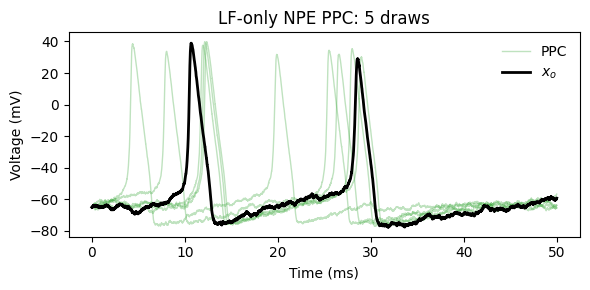

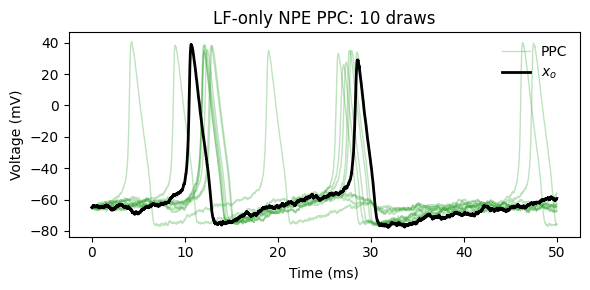

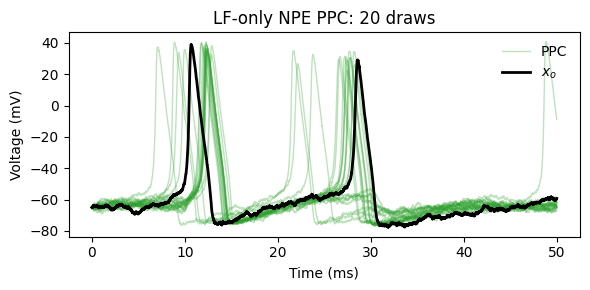

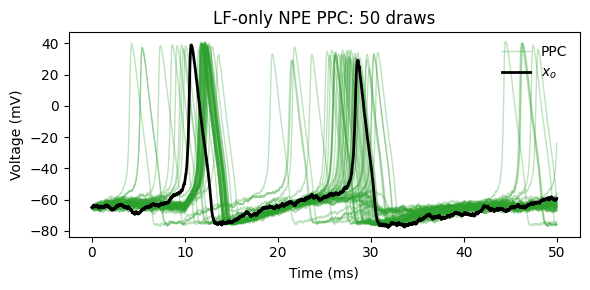

In [10]:
# ─────────────────────────────────────────────────────────────────────────────
# 1. GLOBAL SEED SETTING
# ─────────────────────────────────────────────────────────────────────────────
def set_global_seed(s: int):
    np.random.seed(s)
    torch.manual_seed(s)

# ─────────────────────────────────────────────────────────────────────────────
# 2. CONSTANTS & PATHS
# ─────────────────────────────────────────────────────────────────────────────
ROOT          = pathlib.Path("npe_demo/lf_npe")
OBS_PATH      = pathlib.Path("lf_trace/noisy_ground_truth_trace.npz")
POSTERIOR_DIR = ROOT / "posteriors" / "lf_posterior.pkl"
FIG_DIR       = ROOT / "figures"
FIG_DIR.mkdir(parents=True, exist_ok=True)

N_WORKERS   = 19
SEED_GLOBAL = 2025
SEED_PPC    = 4242

# Set global seed
def set_global_seed(s: int):
    np.random.seed(s)
    torch.manual_seed(s)

set_global_seed(SEED_GLOBAL)

# ─────────────────────────────────────────────────────────────────────────────
# 3. LOAD OBSERVED TRACE & SUMMARY
# ─────────────────────────────────────────────────────────────────────────────
obs = np.load(OBS_PATH)
t_vec = obs["t"]
V_obs = obs["V_lo"]          # observed voltage trace for overlay
x_obs = torch.as_tensor(obs["summary"], dtype=torch.float32)

dt, t_max = t_vec[1] - t_vec[0], t_vec[-1]
print(f"Loaded observed trace (len={len(t_vec)}) from {OBS_PATH}")

# ─────────────────────────────────────────────────────────────────────────────
# 4. LOAD TRAINED POSTERIOR
# ─────────────────────────────────────────────────────────────────────────────
lf_posterior = torch.load(POSTERIOR_DIR, map_location="cpu")
print(f"Loaded posterior from {POSTERIOR_DIR}")

# ─────────────────────────────────────────────────────────────────────────────
# 5. PPC FOR MULTIPLE SAMPLE SIZES
# ─────────────────────────────────────────────────────────────────────────────
sample_sizes = [5, 10, 20, 50]
results_timing = {}

for num_ppc in sample_sizes:
    print(f"\n=== Generating PPC with {num_ppc} draws ===")
    # Sample parameters conditioned on observed summary
    theta_samples = lf_posterior.sample((num_ppc,), x=x_obs)  # (num_ppc, 3)
    theta_list = theta_samples.cpu().numpy().tolist()

    # Simulation worker
    def simulate_one(theta_tuple):
        gNa, gK, gL = theta_tuple
        key = jax.random.PRNGKey(SEED_PPC + int(gNa + gK + gL))
        _, V_lf, *_ = hh_current_noise(
            key      = key,
            gbar_Na  = gNa,
            gbar_K   = gK,
            gbar_L   = gL,
            dt       = dt,
            t_max    = t_max,
            i_delay  = 10.0,
            i_dur    = 20.0,
            i_amp    = 10.0,
            sigma    = 2.0,
        )
        return np.array(V_lf, dtype=np.float32)

    # Run in parallel
    t0 = time.time()
    with mp.Pool(processes=N_WORKERS) as pool:
        V_list = pool.map(simulate_one, theta_list)
    V_ppc = np.stack(V_list, axis=0)
    elapsed = time.time() - t0
    results_timing[f"ppc_{num_ppc}"] = elapsed
    print(f"Generated {num_ppc} traces in {elapsed:.1f}s using {N_WORKERS} cores.")

    # Plot overlay
    plt.figure(figsize=(6,3))
    for i, V in enumerate(V_ppc):
        label = "PPC" if i == 0 else None
        plt.plot(t_vec, V, color="C2", alpha=0.3, linewidth=1, label=label)
    plt.plot(t_vec, V_obs, color="k", linewidth=2, label=r"$x_o$")
    plt.xlabel("Time (ms)")
    plt.ylabel("Voltage (mV)")
    plt.title(f"LF‐only NPE PPC: {num_ppc} draws")
    plt.legend(loc="upper right", frameon=False)
    plt.tight_layout()

    png = FIG_DIR / f"ppc_lf_npe_{num_ppc}.png"
    pdf = FIG_DIR / f"ppc_lf_npe_{num_ppc}.pdf"
    plt.savefig(png, dpi=150)
    plt.savefig(pdf)
    print(f"Saved plots: {png}, {pdf}")

# Save timing info
json.dump(results_timing, open(FIG_DIR / "ppc_timing.json", "w"), indent=2)
print("All PPC generations complete.")

## NPE with low-fidelity simulation on high-fidelity observed data (Misspecified)

In [20]:
# ─────────────────────────────────────────────────────────────────────────────
# 1. GLOBAL SEED SETTING
# ─────────────────────────────────────────────────────────────────────────────
def set_global_seed(s: int):
    np.random.seed(s)
    torch.manual_seed(s)

# ─────────────────────────────────────────────────────────────────────────────
# 2. CONSTANTS & PATHS
# ─────────────────────────────────────────────────────────────────────────────
ROOT            = pathlib.Path("npe_demo/lf_npe")
OBS_PATH_HF     = pathlib.Path("hf_trace/markov_ground_truth_trace.npz")
POSTERIOR_DIR   = ROOT / "posteriors" / "lf_posterior.pkl"
FIG_DIR         = ROOT / "figures"
FIG_DIR.mkdir(parents=True, exist_ok=True)

N_WORKERS   = 19
SEED_GLOBAL = 2025
SEED_PPC    = 4242

# Set global seed
set_global_seed(SEED_GLOBAL)

def Ifunc(t: float) -> float:
    """Step current: 10 µA·cm⁻² from 10 to 30 ms."""
    return 10.0 if 10.0 <= t < 30.0 else 0.0

# ─────────────────────────────────────────────────────────────────────────────
# 3. LOAD HF OBSERVED TRACE & SUMMARY
# ─────────────────────────────────────────────────────────────────────────────
hf_data = np.load(OBS_PATH_HF)
t_vec   = hf_data["t"]
V_obs   = hf_data["V_hi"]     # observed HF voltage trace
x_obs   = torch.as_tensor(hf_data.get("summary"), dtype=torch.float32)

dt, t_max = t_vec[1] - t_vec[0], t_vec[-1]
print(f"Loaded HF observed trace (len={len(t_vec)}) from {OBS_PATH_HF}")

# ─────────────────────────────────────────────────────────────────────────────
# 4. LOAD TRAINED HF POSTERIOR
# ─────────────────────────────────────────────────────────────────────────────
hf_posterior = torch.load(POSTERIOR_DIR, map_location="cpu")
print(f"Loaded HF posterior from {POSTERIOR_DIR}")

# ─────────────────────────────────────────────────────────────────────────────
# 5. PPC FOR MULTIPLE SAMPLE SIZES (HF)
# ─────────────────────────────────────────────────────────────────────────────
sample_sizes = [5, 10, 20, 50]
results_timing = {}

for num_ppc in sample_sizes:
    print(f"\n=== HF PPC with {num_ppc} draws ===")
    # Sample parameters from HF posterior conditioned on observed HF summary
    theta_samples = hf_posterior.sample((num_ppc,), x=x_obs)  # shape: (num_ppc, 3)
    theta_list    = theta_samples.cpu().numpy().tolist()

    # Simulation worker for HF model
    def simulate_hf(theta_tuple):
        gNa, gK, gL = theta_tuple
        # convert to channel counts
        NNa = int(1e4 * gNa / 120.0)
        NK  = int(1e4 * gK  / 36.0)
        # run Markov-HH simulator
        Y = markov_hh(t_vec, Ifunc, NNa=NNa, NK=NK, NoiseModel="MarkovChain")
        return np.array(Y[:,1], dtype=np.float32)

    # Run in parallel
    t0 = time.time()
    with mp.Pool(processes=N_WORKERS) as pool:
        V_list = pool.map(simulate_hf, theta_list)
    V_ppc = np.stack(V_list, axis=0)  # shape: (num_ppc, len(t_vec))
    elapsed = time.time() - t0
    results_timing[f"hf_ppc_{num_ppc}"] = elapsed
    print(f"Generated {num_ppc} HF traces in {elapsed:.1f}s using {N_WORKERS} cores.")

    # Plot overlay
    plt.figure(figsize=(6,3))
    for i, V in enumerate(V_ppc):
        label = "PPC" if i == 0 else None
        plt.plot(t_vec, V, color="C1", alpha=0.3, linewidth=1, label=label)
    # overlay observed
    plt.plot(t_vec, V_obs, color="k", linewidth=2, label=r"$x_{HF}$")
    plt.xlabel("Time (ms)")
    plt.ylabel("Voltage (mV)")
    plt.title(f"HF NPE PPC: {num_ppc} draws")
    plt.legend(loc="upper right", frameon=False)
    plt.tight_layout()

    png = FIG_DIR / f"hf_ppc_{num_ppc}.png"
    pdf = FIG_DIR / f"hf_ppc_{num_ppc}.pdf"
    plt.savefig(png, dpi=150)
    plt.savefig(pdf)
    plt.close()
    print(f"Saved HF PPC plots: {png}, {pdf}")

# Save timing info
json.dump(results_timing, open(FIG_DIR / "hf_ppc_timing.json", "w"), indent=2)
print("All HF PPC generations complete.")

/tmp/ipykernel_642934/1415011488.py:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  hf_posterior = torch.load(POSTERIOR_DIR, map_location="cpu")


Loaded HF observed trace (len=5001) from hf_trace/markov_ground_truth_trace.npz
Loaded HF posterior from npe_demo/lf_npe/posteriors/lf_posterior.pkl

=== HF PPC with 5 draws ===


Drawing 5 posterior samples: 90it [00:00, 4862.90it/s]                          


Generated 5 HF traces in 152.7s using 19 cores.
Saved HF PPC plots: npe_demo/lf_npe/figures/hf_ppc_5.png, npe_demo/lf_npe/figures/hf_ppc_5.pdf

=== HF PPC with 10 draws ===


Drawing 10 posterior samples: 96it [00:00, 14104.92it/s]                        


Generated 10 HF traces in 197.5s using 19 cores.
Saved HF PPC plots: npe_demo/lf_npe/figures/hf_ppc_10.png, npe_demo/lf_npe/figures/hf_ppc_10.pdf

=== HF PPC with 20 draws ===


Drawing 20 posterior samples: 108it [00:00, 12101.54it/s]                       


Generated 20 HF traces in 325.1s using 19 cores.
Saved HF PPC plots: npe_demo/lf_npe/figures/hf_ppc_20.png, npe_demo/lf_npe/figures/hf_ppc_20.pdf

=== HF PPC with 50 draws ===


Drawing 50 posterior samples: 139it [00:00, 23534.97it/s]                       


Generated 50 HF traces in 733.2s using 19 cores.
Saved HF PPC plots: npe_demo/lf_npe/figures/hf_ppc_50.png, npe_demo/lf_npe/figures/hf_ppc_50.pdf
All HF PPC generations complete.


## Self consistent vs Misspecification

/tmp/ipykernel_642934/1510753980.py:47: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  lf_posterior = torch.load(POSTERIOR_DIR, map_location="cpu")


Loaded LF trace from lf_trace/noisy_ground_truth_trace.npz, HF trace from hf_trace/markov_ground_truth_trace.npz
Loaded LF-only posterior from npe_demo/lf_npe/posteriors/lf_posterior.pkl


Drawing 10 posterior samples: 100%|███████████| 10/10 [00:00<00:00, 4710.58it/s]
Drawing 10 posterior samples: 96it [00:00, 8012.36it/s]                         


Simulated 10 PPC traces each in 2.0s


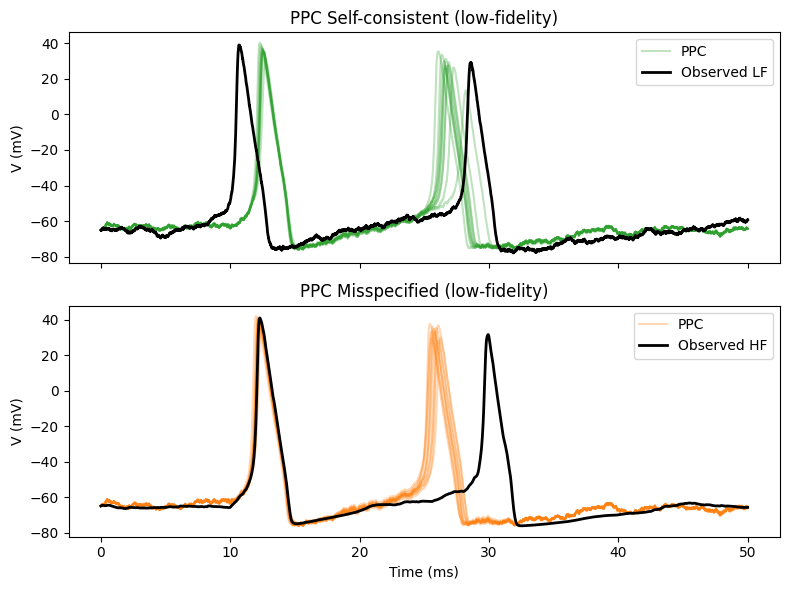

Saved PPC comparison figures to npe_demo/lf_npe/figures


In [25]:
# ─────────────────────────────────────────────────────────────────────────────
# 1. GLOBAL SEED SETTING
# ─────────────────────────────────────────────────────────────────────────────
def set_global_seed(s: int):
    np.random.seed(s)
    torch.manual_seed(s)

# ─────────────────────────────────────────────────────────────────────────────
# 2. CONSTANTS & PATHS
# ─────────────────────────────────────────────────────────────────────────────
ROOT          = pathlib.Path("npe_demo/lf_npe")
OBS_PATH_LF   = pathlib.Path("lf_trace/noisy_ground_truth_trace.npz")
OBS_PATH_HF   = pathlib.Path("hf_trace/markov_ground_truth_trace.npz")
POSTERIOR_DIR = ROOT / "posteriors" / "lf_posterior.pkl"
FIG_DIR       = ROOT / "figures"
FIG_DIR.mkdir(parents=True, exist_ok=True)

N_WORKERS   = 19
SEED_GLOBAL = 2025
SEED_PPC    = 4242

# set seed
def set_global_seed(s):
    np.random.seed(s)
    torch.manual_seed(s)

set_global_seed(SEED_GLOBAL)

# ─────────────────────────────────────────────────────────────────────────────
# 3. LOAD OBSERVED TRACES & SUMMARIES
# ─────────────────────────────────────────────────────────────────────────────
lf_data = np.load(OBS_PATH_LF)
t_vec   = lf_data["t"]
V_lo    = lf_data["V_lo"]
x_lo    = torch.as_tensor(lf_data["summary"], dtype=torch.float32)

hf_data = np.load(OBS_PATH_HF)
V_hi    = hf_data["V_hi"]
# note: summary not needed for LF posterior conditioning on HF

dt, t_max = t_vec[1] - t_vec[0], t_vec[-1]
print(f"Loaded LF trace from {OBS_PATH_LF}, HF trace from {OBS_PATH_HF}")

# ─────────────────────────────────────────────────────────────────────────────
# 4. LOAD LF-NPE POSTERIOR
# ─────────────────────────────────────────────────────────────────────────────
lf_posterior = torch.load(POSTERIOR_DIR, map_location="cpu")
print(f"Loaded LF-only posterior from {POSTERIOR_DIR}")

# ─────────────────────────────────────────────────────────────────────────────
# 5. DRAW PPC SAMPLES AND SIMULATE
# ─────────────────────────────────────────────────────────────────────────────
num_ppc = 10
# draw posterior samples conditioned on LF summary for self-consistent
theta_lo = lf_posterior.sample((num_ppc,), x=x_lo).cpu().numpy().tolist()
# draw posterior samples conditioned on HF summary for misspecified
theta_hi = lf_posterior.sample((num_ppc,), x=torch.as_tensor(hf_data["summary"], dtype=torch.float32))
theta_hi = theta_hi.cpu().numpy().tolist() if isinstance(theta_hi, torch.Tensor) else theta_hi

# worker: simulate LF trace given theta
def simulate_lf(theta_tuple):
    gNa, gK, gL = theta_tuple
    _, V_lf, *_ = hh_current_noise(
        key      = jax.random.PRNGKey(SEED_PPC),
        gbar_Na  = gNa,
        gbar_K   = gK,
        gbar_L   = gL,
        dt       = dt,
        t_max    = t_max,
        i_delay  = 10.0,
        i_dur    = 20.0,
        i_amp    = 10.0,
        sigma    = 2.0,
    )
    return np.array(V_lf, dtype=np.float32)

# simulate in parallel
t0 = time.time()
with mp.Pool(processes=N_WORKERS) as pool:
    V_ppc_lo = np.stack(pool.map(simulate_lf, theta_lo), axis=0)
    V_ppc_hi = np.stack(pool.map(simulate_lf, theta_hi), axis=0)
print(f"Simulated {num_ppc} PPC traces each in {time.time()-t0:.1f}s")

# ─────────────────────────────────────────────────────────────────────────────
# 6. PLOT SELF-CONSISTENT & MISSPECIFIED
# ─────────────────────────────────────────────────────────────────────────────
fig, axes = plt.subplots(2, 1, figsize=(8, 6), sharex=True)

# Top: self-consistent (LF posterior on LF data)
ax = axes[0]
for i in range(num_ppc):
    label = "PPC" if i == 0 else None
    ax.plot(t_vec, V_ppc_lo[i], color="C2", alpha=0.3, label=label)
ax.plot(t_vec, V_lo, color="k", lw=2, label="Observed LF")
ax.set_title("PPC Self-consistent (low-fidelity)")
ax.set_ylabel("V (mV)")
ax.legend()

# Bottom: misspecified (LF posterior on HF data)
ax = axes[1]
for i in range(num_ppc):
    label = "PPC" if i == 0 else None
    ax.plot(t_vec, V_ppc_hi[i], color="C1", alpha=0.3, label=label)
ax.plot(t_vec, V_hi, color="k", lw=2, label="Observed HF")
ax.set_title("PPC Misspecified (low-fidelity)")
ax.set_xlabel("Time (ms)")
ax.set_ylabel("V (mV)")
ax.legend()

plt.tight_layout()

# save
png = FIG_DIR / "ppc_comparison.png"
pdf = FIG_DIR / "ppc_comparison.pdf"
plt.savefig(png, dpi=150)
plt.savefig(pdf)
plt.show()
print(f"Saved PPC comparison figures to {FIG_DIR}")

/tmp/ipykernel_642934/1421798165.py:43: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  hf_posterior = torch.load(POSTERIOR_DIR, map_location="cpu")


Loaded HF trace (len=5001) from hf_trace/markov_ground_truth_trace.npz
torch.load failed ('Invalid magic number; corrupt file?'). Falling back to pickle.load …
Loaded HF posterior via pickle from hf_npe_demo/hf_npe/posterior_hf.pkl


Drawing 10 posterior samples: 100%|█████████████| 10/10 [00:00<00:00, 11.03it/s]


Simulated 10 HF PPC draws in 205.9s using 15 cores


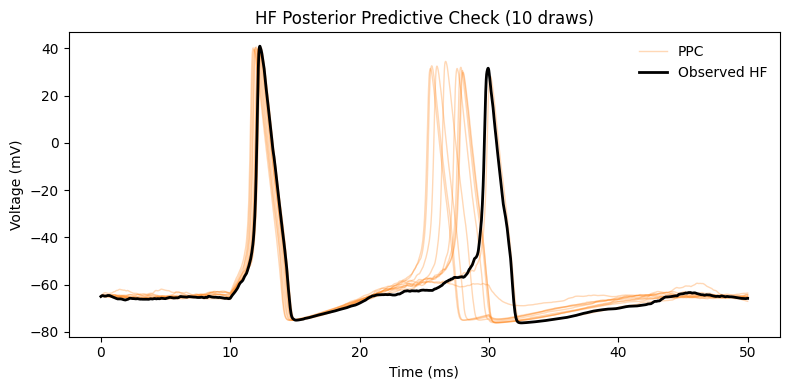

Saved figure to hf_npe_demo/hf_npe/figures/hf_ppc_10.png


In [30]:
# ---------------------------------------------------------------------------
# 1. GLOBAL SEED SETTING
# ---------------------------------------------------------------------------
def set_global_seed(s: int):
    np.random.seed(s)
    torch.manual_seed(s)

# ---------------------------------------------------------------------------
# 2. CONSTANTS & PATHS (HF‑only)
# ---------------------------------------------------------------------------
ROOT          = pathlib.Path("hf_npe_demo/hf_npe")  # high‑fidelity workspace
OBS_PATH_HF   = pathlib.Path("hf_trace/markov_ground_truth_trace.npz")
POSTERIOR_DIR = ROOT / "posterior_hf.pkl"           # HF posterior file
FIG_DIR       = ROOT / "figures"
FIG_DIR.mkdir(parents=True, exist_ok=True)

N_WORKERS   = 15
SEED_GLOBAL = 2025
SEED_PPC    = 4242

set_global_seed(SEED_GLOBAL)

# HF stimulus

def Ifunc(t: float) -> float:
    return 10.0 if 10.0 <= t < 30.0 else 0.0

# ---------------------------------------------------------------------------
# 3. LOAD HF OBSERVATION
# ---------------------------------------------------------------------------
hf = np.load(OBS_PATH_HF)
t_vec = hf["t"]
V_obs = hf["V_hi"]
x_obs = torch.as_tensor(hf["summary"], dtype=torch.float32)

dt, t_max = t_vec[1] - t_vec[0], t_vec[-1]
print(f"Loaded HF trace (len={len(t_vec)}) from {OBS_PATH_HF}")

# ---------------------------------------------------------------------------
# 4. LOAD HF POSTERIOR (fallback to pickle if torch.load fails)
# ---------------------------------------------------------------------------
try:
    hf_posterior = torch.load(POSTERIOR_DIR, map_location="cpu")
    print(f"Loaded HF posterior via torch.load from {POSTERIOR_DIR}")
except (RuntimeError, ValueError) as e:
    print(f"torch.load failed ('{e}'). Falling back to pickle.load …")
    with open(POSTERIOR_DIR, "rb") as f:
        hf_posterior = pickle.load(f)
    print(f"Loaded HF posterior via pickle from {POSTERIOR_DIR}")

# ---------------------------------------------------------------------------
# 5. PPC (10 draws, HF simulation)
# ---------------------------------------------------------------------------
NUM_PPC = 10

# sample θ from posterior conditioned on HF summary
theta_samples = hf_posterior.sample((NUM_PPC,), x=x_obs).cpu().numpy().tolist()

# worker to simulate HF trace
def simulate_hf(theta):
    gNa, gK, gL = theta
    NNa = int(1e4 * gNa / 120.0)
    NK  = int(1e4 * gK  / 36.0)
    Y = markov_hh(t_vec, Ifunc, NNa=NNa, NK=NK, NoiseModel="MarkovChain")
    return np.array(Y[:, 1], dtype=np.float32)

start = time.time()
with mp.Pool(processes=N_WORKERS) as pool:
    V_ppc = np.stack(pool.map(simulate_hf, theta_samples), axis=0)
print(f"Simulated {NUM_PPC} HF PPC draws in {time.time()-start:.1f}s using {N_WORKERS} cores")

# ---------------------------------------------------------------------------
# 6. PLOT PPC OVERLAY
# ---------------------------------------------------------------------------
plt.figure(figsize=(8,4))
for i, V in enumerate(V_ppc):
    lbl = "PPC" if i == 0 else None
    plt.plot(t_vec, V, color="C1", alpha=0.3, linewidth=1, label=lbl)
plt.plot(t_vec, V_obs, color="k", lw=2, label="Observed HF")
plt.xlabel("Time (ms)")
plt.ylabel("Voltage (mV)")
plt.title("HF Posterior Predictive Check (10 draws)")
plt.legend(frameon=False)
plt.tight_layout()

png = FIG_DIR / "hf_ppc_10.png"
pdf = FIG_DIR / "hf_ppc_10.pdf"
plt.savefig(png, dpi=150)
plt.savefig(pdf)
plt.show()
print(f"Saved figure to {png}")